In [31]:
import json 
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import random
import os
import time
from sklearn.model_selection import *
from sklearn.metrics import f1_score
from transformers import *
import matplotlib.pyplot as plt

In [39]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [2]:
CFG = {
    'fold_num': 5,
    'seed': 42,
#     'model': 'hfl/chinese-macbert-base',
    'model': 'nghuyong/ernie-1.0',
    'max_len': 512, 
    'epochs': 5,
    'train_bs': 30, 
    'valid_bs': 30,
    'lr': 2e-5, 
    'num_workers': 0,
    'accum_iter': 1, 
    'weight_decay': 1e-6, 
    'device': 0,
}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['seed'])

torch.cuda.set_device(CFG['device'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_df =  pd.read_csv('train.csv')
train_new_df =  pd.read_csv('train_new.csv')

In [5]:
train_df.fillna(-1, inplace=True)
train_new_df.fillna(-1, inplace=True)

In [20]:
t = '英国伦敦，20/21赛季英超第20轮，托特纳姆热刺VS利物浦。热刺本赛季18轮联赛是9胜6平3负，目前积33分排名联赛第5位。'
for i in tqdm(range(len(train_df))):
    if t in train_df.loc[i,'source']:
        print(train_df.loc[i])

 26%|██▌       | 43551/168714 [00:00<00:00, 143989.48it/s]

source    英国伦敦，20/21赛季英超第20轮，托特纳姆热刺VS利物浦。热刺本赛季18轮联赛是9胜6平...
target     北京时间1月29日凌晨4时，英超联赛第20轮迎来一场强强对话，热刺坐镇主场迎战利物浦。  ...
labelA                                                 -1.0
labelB                                                  0.0
type                                                     ss
len1                                                    146
len2                                                    150
Name: 28327, dtype: object
source    英国伦敦，20/21赛季英超第20轮，托特纳姆热刺VS利物浦。热刺本赛季18轮联赛是9胜6平...
target     北京时间1月29日凌晨4时，英超联赛第20轮迎来一场强强对话，热刺坐镇主场迎战利物浦。  ...
labelA                                                  1.0
labelB                                                 -1.0
type                                                     ss
len1                                                    146
len2                                                    150
Name: 34125, dtype: object


100%|██████████| 168714/168714 [00:01<00:00, 143464.45it/s]


In [25]:
train_df.loc[28327].values

array(['英国伦敦，20/21赛季英超第20轮，托特纳姆热刺VS利物浦。热刺本赛季18轮联赛是9胜6平3负，目前积33分排名联赛第5位。利物浦本赛季19轮联赛是9胜7平3负，目前积34分排名联赛第4位。从目前的走势来看，本场比赛从热刺的角度来讲，是非常被动的。最终，本场比赛的比分为托特纳姆热刺1-3利',
       ' 北京时间1月29日凌晨4时，英超联赛第20轮迎来一场强强对话，热刺坐镇主场迎战利物浦。  热刺vs利物浦，比赛看点如下： 第一：热刺能否成功复仇？双方首回合，热刺客场1-2被利物浦绝杀，赛后穆里尼奥称最好的球队输了，本轮热刺主场迎战利物浦，借着红军5轮不胜的低迷状态，能否成功复仇？ 第二：利物浦近',
       -1.0, 0.0, 'ss', 146, 150], dtype=object)

In [6]:
files = ['ernie_round1_train.npy',
'ernie_round2_train.npy',
'ernie_round3_train.npy',
'maclarge_round1_train.npy',
'maclarge_round3_train.npy',
'macbase_round1_train.npy',
'macbase_round2_train.npy',
'macbase_round3_train.npy',
]

probs = []
for file in files:
    prob = np.load(file)
    probs.append(prob)

In [7]:
probs = np.mean(probs,0)

In [8]:
files = ['ernie_round1_train_new.npy',
'ernie_round2_train_new.npy',
'ernie_round3_train_new.npy',
'maclarge_round1_train_new.npy',
'maclarge_round3_train_new.npy',
'macbase_round1_train_new.npy',
'macbase_round2_train_new.npy',
'macbase_round3_train_new.npy',
]

probs_new = []
for file in files:
    prob = np.load(file)
    probs_new.append(prob)
probs_new = np.mean(probs_new,0)

In [9]:
probs.shape, probs_new.shape

((168714, 2), (96777, 2))

In [10]:
all_probs = np.concatenate([probs, probs_new],0)

In [26]:
train_df = pd.concat([train_df, train_new_df], 0).reset_index()

In [27]:
train_df['stratify'] = 3*(train_df.labelA+1)+train_df.labelB+1

In [28]:
train_df

,index,source,target,labelA,labelB,type,len1,len2,stratify
0,0,谁能打破科比81分纪录？奥尼尔给出5个候选人，补充利拉德比尔！,NBA现役能入名人堂的球星很多，但是能被立铜像只有2人,0.0,-1.0,ss,31,27,3.0
1,1,请扩散！明天，黄金埠这些地方会停电！,生活｜这几个地方注意啦！1月12日有部分线路停电检修,0.0,-1.0,ss,18,26,3.0
2,2,居家健身增强免疫！（三）,原来是背影杀手#你愿意和我做朋友吗#户外健身,0.0,-1.0,ss,12,22,3.0
3,3,太极拳罗师傅被洋人打伤，叶问霸气复仇？,非常完美：感动！女嘉宾告白赵杰被拒绝，尹康霸气上台挽留！,0.0,-1.0,ss,19,30,3.0
4,4,恭喜哈登！篮网因祸得福，29+7超巨大概率复出，3换4交易方案出炉,三英缺席杜兰特，篮网迎战湖人NBA重头大戏！,1.0,-1.0,ss,33,22,6.0
...,...,...,...,...,...,...,...,...,...
265486,96772,北京时间1月9日，CBA第28轮的一场比赛率先开打，北控男篮对阵上海男篮，近期状态不错的上海...,北京时间1月13日，上海神塔董瀚麟打出大爆发一战，面对与周琦、莫泰的双塔对决，他奉献7中7...,-1.0,0.0,ll,788,652,1.0
265487,96773,桌球界金童玉女江宏杰、福原爱爆婚姻亮红灯。（图／翻摄自福原爱脸书） 桌球界金童玉女江宏杰、...,福原爱江宏杰 搜狐娱乐讯据台媒，福原爱与小5岁早稻田学弟约会出游，陷入不伦疑云，与江宏杰4年...,-1.0,1.0,ll,524,1142,2.0
265488,96774,现在的NBA联盟和之前根本不一样了，如今的联盟更加注重的是几个球星在一起联手夺冠，如果你还在...,4月3日·周六10:00 雄鹿（客）VS开拓者（主） 场外因素 字母哥和利拉德，可以说是目前...,-1.0,0.0,ll,567,593,1.0
265489,96775,近年来，智能技术的普及应用给人们的生活带来了便利，但也给部分老年人带来了烦恼和难题。随着中国...,科学技术的发展，在便利了年轻群体的同时，也让没能跟上步伐的老年人群体，逐渐面临“数字鸿沟”。...,-1.0,0.0,ll,1665,701,1.0


In [83]:
train_df.query('len1+len2 < 15')

,index,source,target,labelA,labelB,type,len1,len2,stratify
379,379,警惕！7人感染,早知天下事,0.0,-1.0,ss,7,5,3.0
2301,2301,新年快乐,政已阅祝您新年快乐！,1.0,-1.0,ss,4,10,6.0
2616,2616,>>A02,戳图查看详情↑,0.0,-1.0,ss,5,7,3.0
3000,3000,电影里的图片,电影里的图片,1.0,-1.0,ss,6,6,6.0
3035,3035,电影里面的图片,电影里面的图片,1.0,-1.0,ss,7,7,6.0
...,...,...,...,...,...,...,...,...,...
191738,23024,备年货迎新春,备年货迎新春,-1.0,1.0,ss,6,6,2.0
192129,23415,惊蛰日，学雷锋,惊蛰日，学雷锋,-1.0,1.0,ss,7,7,2.0
192146,23432,兑彩票,兑彩票,-1.0,1.0,ss,3,3,2.0
192543,23829,发个库存照片,最后一个库存,-1.0,0.0,ss,6,8,1.0


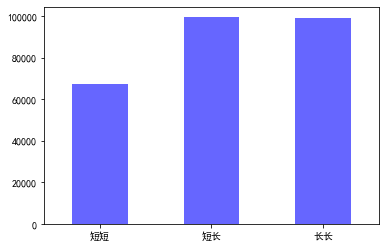

In [79]:
train_df.type.value_counts().sort_index(ascending=False).plot.bar(color="blue",alpha=0.6)
plt.xticks(range(3),['短短','短长','长长'],rotation=0)
plt.show()

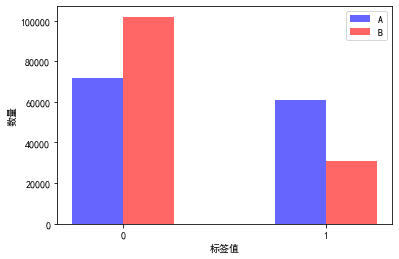

In [73]:
bar_width = 0.25
x = np.arange(2)
y1 = train_df.query('labelA != -1').labelA.value_counts()
y2 = train_df.query('labelB != -1').labelB.value_counts()
plt.bar(x,y1,bar_width,color="blue",align="center",label="A",alpha=0.6)
plt.bar(x+bar_width,y2,bar_width,color="red",align="center",label="B",alpha=0.6)
plt.xlabel("标签值")
plt.ylabel("数量")
plt.xticks(x+bar_width/2,[0,1])
plt.legend()
plt.show()

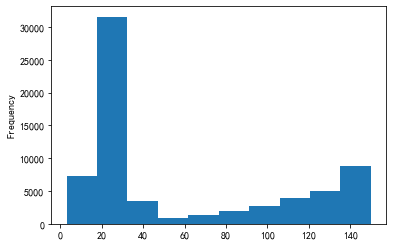

(count    67162.000000
 mean        59.734657
 std         48.766638
 min          3.000000
 25%         24.000000
 50%         30.000000
 75%        110.000000
 max        150.000000
 Name: len1, dtype: float64,
 count    67162.000000
 mean        60.190539
 std         48.455424
 min          3.000000
 25%         24.000000
 50%         31.000000
 75%        110.000000
 max        150.000000
 Name: len2, dtype: float64)

In [75]:
train_df.query('type==\'ss\'').len1.plot.hist()

plt.show()

train_df.query('type==\'ss\'').len1.describe(),train_df.query('type==\'ss\'').len2.describe()

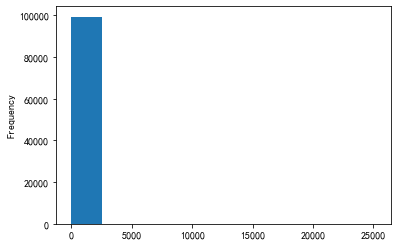

(count    99527.000000
 mean       106.265958
 std        266.909012
 min          3.000000
 25%         26.000000
 50%         39.000000
 75%        128.000000
 max      25184.000000
 Name: len1, dtype: float64,
 count     99527.000000
 mean       1003.299788
 std        1282.737142
 min           4.000000
 25%         467.000000
 50%         783.000000
 75%        1204.000000
 max      183608.000000
 Name: len2, dtype: float64)

In [76]:
train_df.query('type==\'sl\'').len1.plot.hist()
# train_df.query('type==\'ss\'').len2.plot.hist()
plt.show()

train_df.query('type==\'sl\'').len1.describe(),train_df.query('type==\'sl\'').len2.describe()

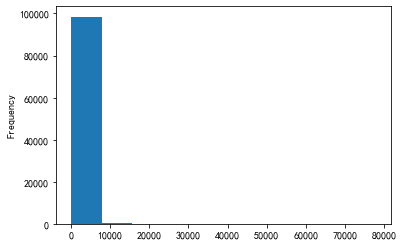

(count    98802.000000
 mean      1112.845681
 std       1222.216924
 min        100.000000
 25%        559.000000
 50%        851.000000
 75%       1291.000000
 max      77827.000000
 Name: len1, dtype: float64,
 count    98802.000000
 mean      1111.824568
 std       1174.277097
 min        104.000000
 25%        555.000000
 50%        851.000000
 75%       1287.000000
 max      46249.000000
 Name: len2, dtype: float64)

In [77]:
train_df.query('type==\'ll\'').len1.plot.hist()
# train_df.query('type==\'ss\'').len2.plot.hist()
plt.show()

train_df.query('type==\'ll\'').len1.describe(),train_df.query('type==\'ll\'').len2.describe()

In [14]:
tokenizer = BertTokenizer.from_pretrained(CFG['model'])

In [15]:
class MyDataset(Dataset):
    def __init__(self, dataframe, probs=None):
        self.df = dataframe
        self.probs = probs
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text1 = str(self.df.source.values[idx])
        text2 = str(self.df.target.values[idx])
        
        prob = self.probs[idx]
        
        label1 = self.df.labelA.values[idx]
        label2 = self.df.labelB.values[idx]
        
        return text1, text2, label1, label2, prob

In [16]:
def collate_fn(data):
    text = tokenizer([x[0] for x in data], text_pair=[x[1] for x in data], padding='max_length', truncation=True, max_length=CFG['max_len'], return_tensors='pt')
    input_ids = text['input_ids']
    attention_mask = text['attention_mask']
    token_type_ids = text['token_type_ids']
    label1 = torch.LongTensor([x[2] for x in data])
    label2 = torch.LongTensor([x[3] for x in data])
    prob = torch.Tensor([x[4] for x in data])
    return input_ids, attention_mask, token_type_ids, label1, label2, prob

In [17]:
class Model(nn.Module):

    def __init__(self, CFG):
        super(Model, self).__init__()
        self.bert = BertModel.from_pretrained(CFG['model'])
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 2)
        self.fc2 = nn.Linear(self.bert.config.hidden_size, 2)
 
    def forward(self, input_ids, attention_mask, token_type_ids):
        text = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[1]
        y1 = self.fc1(text)
        y2 = self.fc2(text)
        return y1, y2

In [18]:
class FGM():
    def __init__(self, model):
        self.model = model
        self.backup = {}

    def attack(self, epsilon=0.1, emb_name='word_embeddings'):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                self.backup[name] = param.data.clone()
                norm = torch.norm(param.grad)
                if norm != 0:
                    r_at = epsilon * param.grad / norm
                    param.data.add_(r_at)

    def restore(self, emb_name='word_embeddings'):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                assert name in self.backup
                param.data = self.backup[name]
            self.backup = {}

In [19]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
def train_model(model, train_loader):
    model.train() 
    fgm = FGM(model)
    
    losses = AverageMeter()
    
    optimizer.zero_grad()
    
    tk = tqdm(train_loader, total=len(train_loader), position=0, leave=True)
    for step, batch in enumerate(tk):
        input_ids, attention_mask, token_type_ids, y1, y2, prob = batch
        
        input_ids, attention_mask, token_type_ids = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device)
        y1, y2, prob = y1.to(device), y2.to(device), prob.to(device)
        
        with autocast():
            output1, output2 = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(output1, y1) / 2 + criterion(output2, y2) / 2
            
            idx1 = y1>-1
            if idx1.sum():
                loss += nn.KLDivLoss()(F.log_softmax(output1[idx1], dim=1), prob[idx1])
            idx2 = y2>-1
            if idx2.sum():
                loss += nn.KLDivLoss()(F.log_softmax(output2[idx2], dim=1), prob[idx2])

        scaler.scale(loss).backward()
        
        # 对抗训练
        fgm.attack() # 在embedding上添加对抗扰动
        with autocast():
            output1, output2 = model(input_ids, attention_mask, token_type_ids)
            loss_adv = criterion(output1, y1) / 2 + criterion(output2, y2) / 2
            
            idx1 = y1>-1
            if idx1.sum():
                loss_adv += nn.KLDivLoss()(F.log_softmax(output1[idx1], dim=1), prob[idx1])
            idx2 = y2>-1
            if idx2.sum():
                loss_adv += nn.KLDivLoss()(F.log_softmax(output2[idx2], dim=1), prob[idx2])
        scaler.scale(loss_adv).backward() # 反向传播，并在正常的grad基础上，累加对抗训练的梯度
        fgm.restore() # 恢复embedding参数

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad() 
        scheduler.step()
            
        lr = optimizer.param_groups[-1]['lr']

        losses.update(loss.item(), y1.size(0))
        tk.set_postfix(loss=losses.avg, lr=lr)
  
    return losses.avg


def test_model(model, val_loader):
    model.eval()
    
    losses = AverageMeter()

    y_truth1, y_pred1 = [], []
    y_truth2, y_pred2 = [], []
    
    with torch.no_grad():
        tk = tqdm(val_loader, total=len(val_loader), position=0, leave=True)
        for step, (input_ids, attention_mask, token_type_ids, y1, y2, prob) in enumerate(tk):
            input_ids, attention_mask, token_type_ids = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device)
            y1, y2, prob = y1.to(device), y2.to(device), prob.to(device)
        
            output1, output2 = model(input_ids, attention_mask, token_type_ids)
            
            loss = criterion(output1, y1) / 2 + criterion(output2, y2) / 2
        
            losses.update(loss.item(), y1.size(0))
            tk.set_postfix(loss=losses.avg)
            
            idx1 = y1>-1
            if idx1.sum():
                y_truth1.extend(y1[idx1].cpu().numpy())
                y_pred1.extend(output1[idx1].softmax(1)[:,1].cpu().numpy())
            idx2 = y2>-1
            if idx2.sum():
                y_truth2.extend(y2[idx2].cpu().numpy())
                y_pred2.extend(output2[idx2].softmax(1)[:,1].cpu().numpy())
  
    def best_f1(y_truth, y_pred):   
        thresholds = []
        for thresh in np.arange(0.4, 0.61, 0.1):
            thresh = np.round(thresh, 2)
            res = f1_score(y_truth, (y_pred >= thresh).astype(int))
            thresholds.append([thresh, res])
        thresholds.sort(key=lambda x: x[1], reverse=True)
        best_thresh = thresholds[0][0]
        best_score = thresholds[0][1]
        print(thresholds)
        return best_score
    
    f1 = (best_f1(y_truth1, y_pred1) + best_f1(y_truth2, y_pred2)) / 2
       
    return losses.avg, f1

In [20]:
def log(s):
    with open('log.txt','a')as f:
        f.write(str(s)+'\n')

In [21]:
seed_everything(CFG['seed'])

folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed'])\
                    .split(np.arange(train_df.shape[0]), train_df['stratify'].values)

cv = [] 

for fold, (trn_idx, val_idx) in enumerate(folds):
    
    print(fold)
    
    log(fold)
    
    if fold != 0:
        continue

    train = train_df.loc[trn_idx]
    val = train_df.loc[val_idx]
    
    train_set = MyDataset(train, all_probs[trn_idx])
    val_set = MyDataset(val, all_probs[val_idx])
    
    train_loader = DataLoader(train_set, batch_size=CFG['train_bs'], collate_fn=collate_fn, shuffle=True, num_workers=CFG['num_workers'])
    val_loader = DataLoader(val_set, batch_size=CFG['valid_bs'], collate_fn=collate_fn, shuffle=False, num_workers=CFG['num_workers'])
    
    steps_per_epoch = len(train_loader)
    
    best_f1 = 0
    
    model =  Model(CFG).to(device)

    scaler = GradScaler()
    optimizer = AdamW(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
    criterion = nn.CrossEntropyLoss(ignore_index=-1)
    scheduler = get_cosine_schedule_with_warmup(optimizer, 0.05*CFG['epochs']*steps_per_epoch, CFG['epochs']*steps_per_epoch)

    for epoch in range(CFG['epochs']):

        print('epoch:',epoch)
        time.sleep(0.2)

        train_loss = train_model(model, train_loader)
        val_loss, val_f1 = test_model(model, val_loader)
        
        print(val_f1)
        log(val_f1)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), '{}_fold_{}.pt'.format(CFG['model'].split('/')[-1], fold))
            
    cv.append(best_f1) 

0
epoch: 0


  0%|          | 0/7080 [00:00<?, ?it/s]c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 1770/1770 [13:06<00:00,  2.25it/s, loss=0.172]


[[0.4, 0.821950321234194], [0.5, 0.8079269611873134], [0.6, 0.7849070360918702]]
[[0.4, 0.6738376127689105], [0.5, 0.6367183782240411], [0.6, 0.5911975860992613]]
0.7478939670015523
epoch: 1


  0%|          | 0/7080 [00:00<?, ?it/s]c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 1770/1770 [13:04<00:00,  2.25it/s, loss=0.168]


[[0.4, 0.828501543766791], [0.5, 0.8208754208754209], [0.6, 0.8050059489710483]]
[[0.4, 0.7016208812114756], [0.5, 0.6877873443116276], [0.6, 0.6553357481192532]]
0.7650612124891333
epoch: 2


  0%|          | 0/7080 [00:00<?, ?it/s]c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 1770/1770 [13:05<00:00,  2.25it/s, loss=0.166]


[[0.4, 0.8305915156343359], [0.5, 0.8247775782131073], [0.6, 0.8097578097578096]]
[[0.4, 0.7000964320154291], [0.5, 0.6759575773512139], [0.6, 0.6440516005733398]]
0.7653439738248825
epoch: 3


  0%|          | 0/7080 [00:00<?, ?it/s]c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 1770/1770 [13:03<00:00,  2.26it/s, loss=0.166]


[[0.4, 0.8299972254151968], [0.5, 0.8265554683951942], [0.6, 0.8167692506348729]]
[[0.4, 0.7026985469362651], [0.5, 0.6916088536504789], [0.6, 0.6694725530581178]]
0.7663478861757309
epoch: 4


  0%|          | 0/7080 [00:00<?, ?it/s]c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 1770/1770 [13:07<00:00,  2.25it/s, loss=0.167]

[[0.4, 0.8305206177360293], [0.5, 0.8245853497125367], [0.6, 0.8174586110513868]]
[[0.4, 0.6994757843674205], [0.5, 0.6873215785054576], [0.6, 0.6638883855770973]]
0.7649982010517249
1
2
3
4


In [22]:
cv

[0.7663478861757309]

In [ ]:
np.mean(cv)

In [23]:
seed_everything(CFG['seed'])


train_set = MyDataset(train_df, all_probs)

train_loader = DataLoader(train_set, batch_size=CFG['train_bs'], collate_fn=collate_fn, shuffle=True, num_workers=CFG['num_workers'])

steps_per_epoch = len(train_loader)

model =  Model(CFG).to(device)

scaler = GradScaler()
optimizer = AdamW(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
criterion = nn.CrossEntropyLoss(ignore_index=-1)
scheduler = get_cosine_schedule_with_warmup(optimizer, 0.05*CFG['epochs']*steps_per_epoch, CFG['epochs']*steps_per_epoch)

for epoch in range(4):

    print('epoch:',epoch)
    time.sleep(0.2)

    train_loss = train_model(model, train_loader)
    
    torch.save(model.state_dict(), '{}_full_epoch_{}.pt'.format(CFG['model'].split('/')[-1], epoch))

epoch: 0


  0%|          | 0/8850 [00:00<?, ?it/s]c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 8850/8850 [3:33:51<00:00,  1.45s/it, loss=0.388, lr=1.88e-5]  


epoch: 1


100%|██████████| 8850/8850 [2:34:41<00:00,  1.05s/it, loss=0.325, lr=1.4e-5]   


epoch: 2


100%|██████████| 8850/8850 [2:36:16<00:00,  1.06s/it, loss=0.288, lr=7.55e-6]  


epoch: 3


100%|██████████| 8850/8850 [2:36:57<00:00,  1.06s/it, loss=0.262, lr=2.11e-6]  


In [25]:
CFG = {
    'fold_num': 5,
    'seed': 42,
    'model': 'hfl/chinese-macbert-base',
#     'model': 'nghuyong/ernie-1.0',
    'max_len': 512, 
    'epochs': 5,
    'train_bs': 30, 
    'valid_bs': 30,
    'lr': 2e-5, 
    'num_workers': 0,
    'accum_iter': 1, 
    'weight_decay': 1e-6, 
    'device': 0,
}
tokenizer = BertTokenizer.from_pretrained(CFG['model'])

seed_everything(CFG['seed'])


train_set = MyDataset(train_df, all_probs)

train_loader = DataLoader(train_set, batch_size=CFG['train_bs'], collate_fn=collate_fn, shuffle=True, num_workers=CFG['num_workers'])

steps_per_epoch = len(train_loader)

model =  Model(CFG).to(device)

scaler = GradScaler()
optimizer = AdamW(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
criterion = nn.CrossEntropyLoss(ignore_index=-1)
scheduler = get_cosine_schedule_with_warmup(optimizer, 0.05*CFG['epochs']*steps_per_epoch, CFG['epochs']*steps_per_epoch)

for epoch in range(4):

    print('epoch:',epoch)
    time.sleep(0.2)

    train_loss = train_model(model, train_loader)
    
    torch.save(model.state_dict(), '{}_full_epoch_{}.pt'.format(CFG['model'].split('/')[-1], epoch))

epoch: 0


100%|██████████| 8850/8850 [2:46:47<00:00,  1.13s/it, loss=0.394, lr=1.88e-5]  


epoch: 1


100%|██████████| 8850/8850 [2:42:56<00:00,  1.10s/it, loss=0.326, lr=1.4e-5]   


epoch: 2


100%|██████████| 8850/8850 [2:42:46<00:00,  1.10s/it, loss=0.283, lr=7.55e-6]  


epoch: 3


100%|██████████| 8850/8850 [2:43:10<00:00,  1.11s/it, loss=0.248, lr=2.11e-6]  


In [ ]:
CFG = {
    'fold_num': 5,
    'seed': 42,
    'model': 'hfl/chinese-macbert-large',
#     'model': 'nghuyong/ernie-1.0',
    'max_len': 512, 
    'epochs': 5,
    'train_bs': 8, 
    'valid_bs': 8,
    'lr': 1e-5, 
    'num_workers': 0,
    'accum_iter': 1, 
    'weight_decay': 1e-6, 
    'device': 0,
}
tokenizer = BertTokenizer.from_pretrained(CFG['model'])

seed_everything(CFG['seed'])


train_set = MyDataset(train_df, all_probs)

train_loader = DataLoader(train_set, batch_size=CFG['train_bs'], collate_fn=collate_fn, shuffle=True, num_workers=CFG['num_workers'])

steps_per_epoch = len(train_loader)

model =  Model(CFG).to(device)

scaler = GradScaler()
optimizer = AdamW(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
criterion = nn.CrossEntropyLoss(ignore_index=-1)
scheduler = get_cosine_schedule_with_warmup(optimizer, 0.05*CFG['epochs']*steps_per_epoch, CFG['epochs']*steps_per_epoch)

for epoch in range(4):

    print('epoch:',epoch)
    time.sleep(0.2)

    train_loss = train_model(model, train_loader)
    
    torch.save(model.state_dict(), '{}_full_epoch_{}.pt'.format(CFG['model'].split('/')[-1], epoch))

epoch: 0


  0%|          | 0/33187 [00:00<?, ?it/s]c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
  3%|▎         | 915/33187 [13:21<8:07:18,  1.10it/s, loss=0.864, lr=1.1e-6] 